# Señales de tráfico en Bélgica

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [54]:
train_path = "../datasets/belgian/Training"

data = pd.DataFrame()

for i in range(62):
    if i < 10:
        dir_path = "0000" + str(i)
        filepath = "GT-0000" + str(i)
    else:
        dir_path = "000" + str(i)
        filepath = "GT-000" + str(i)
    
    df = pd.read_csv(os.path.join(train_path, dir_path, filepath + ".csv"), sep=";")
    df["Filename"] = [plt.imread(os.path.join(train_path, dir_path, x)) for x in df["Filename"]]
    data = pd.concat([data, df], axis=0).reset_index(drop=True)

data = data.rename(columns={"Filename": "Image"})
data.head()

,Image,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,"[[[210, 249, 232], [204, 249, 208], [197, 198,...",141,142,12,12,128,130,0
1,"[[[38, 48, 32], [40, 48, 30], [40, 47, 27], [4...",120,123,10,10,109,113,0
2,"[[[123, 75, 51], [111, 69, 45], [102, 67, 42],...",105,107,9,9,96,98,0
3,"[[[91, 80, 55], [90, 77, 54], [91, 78, 58], [9...",94,105,8,9,86,95,0
4,"[[[49, 45, 30], [50, 45, 31], [51, 45, 32], [5...",128,139,11,12,117,127,0


In [40]:
data.shape

(4591, 8)

In [39]:
data["ClassId"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

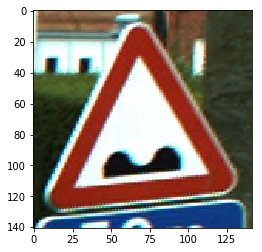

In [44]:
plt.imshow(data["Image"][0])

In [71]:
images = data.Image
y_target = np.array(data.ClassId)

In [63]:
width = 9999999
height = 9999999

for image in data["Image"]:
    if image.shape[1] < width:
        width = image.shape[1]
    if image.shape[0] < height:
        height = image.shape[0]
        
print("Mimum size: {}x{}".format(height, width))

Mimum size: 22x20


In [61]:
import skimage

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [85]:
images = np.array([skimage.transform.resize(x, output_shape=(30,30)) for x in images])

In [86]:
x_train, x_test, y_train, y_test = train_test_split(images, y_target, test_size=0.2, random_state=101)

In [87]:
x_train.shape, x_test.shape

((3672, 30, 30, 3), (919, 30, 30, 3))

### Convolutional Neural Network

In [74]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [94]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [95]:
cnn = Sequential()

# First convolutional layer
cnn.add(Conv2D(filters=250, kernel_size=(3,3), activation="relu", input_shape=(30,30,3)))
cnn.add(BatchNormalization())

# Second convolutional layer
cnn.add(Conv2D(filters=100, kernel_size=(3,3), activation="relu"))
cnn.add(BatchNormalization())

# Max pooling layer
cnn.add(MaxPool2D(strides=(1,1)))
# Flatten layer
cnn.add(Flatten())

# First fully connected layer
cnn.add(Dense(units=100, activation="relu"))
cnn.add(BatchNormalization())

# Last fully connected layer (output)
cnn.add(Dense(units=62, activation="softmax"))

In [96]:
cnn.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
variable_lr = LearningRateScheduler(lambda x: 1e-3*0.9**x)

In [97]:
datagen = ImageDataGenerator(zoom_range=0.1, 
                             height_shift_range=0.1, 
                             width_shift_range=0.1, 
                             rotation_range=10)

In [ ]:
training = cnn.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=20), 
                             epochs=10, 
                             steps_per_epoch=300, 
                             validation_data=(x_test[:300,], y_test[:300,]), 
                             callbacks=[variable_lr])

Epoch 1/10
300/300 [==============================] - 143s 476ms/step - loss: 1.5885 - acc: 0.6132 - val_loss: 0.6761 - val_acc: 0.8333
Epoch 2/10
 70/300 [======>.......................] - ETA: 2:07 - loss: 0.7557 - acc: 0.8121